# Notebook to run gPhoton
Run gPhoton to create GALEX light curves etc.
Setup your source parameter and setting in the cell below.

In [1]:
from astropy.io import ascii
from astropy import units as uu

src_str = """label	ra	dec
WD900 215.3258439968967	52.596545351520945"""
tt_srcs = ascii.read(src_str)
outdir = "./resources/gPhoton_out/"
outfile_fin = outdir+"gPhoton_"+str(tt_srcs["label"][0])+'_fin.npy'
outfile_app = outdir+"gPhoton_"+str(tt_srcs["label"][0])+'_app.npy'
ron = (5*uu.arcsec).to(uu.deg).value        # Radius of signal annulus
roff1 = (17*uu.arcsec).to(uu.deg).value      # Inner radius of background ring
roff2 = (20*uu.arcsec).to(uu.deg).value      # Outer radius of background ring
#load_past_results = False

In [2]:
%matplotlib widget
import gPhoton
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import os
from vasca.utils import mag2flux, flux2mag, tgalex_to_astrotime
import vasca.visualization as vvis
from vasca.region import Region

### Do aperture photometry for each visit with gPhoton

In [3]:
%%time
pos_ra = tt_srcs["ra"][0]
pos_dec = tt_srcs["dec"][0]

#Run or load gFind
if os.path.isfile(outfile_fin):
    dd_gfind = np.load(outfile_fin,allow_pickle='TRUE').item()
    t_bins = list(zip(dd_gfind["NUV"]["t0"],dd_gfind["NUV"]["t1"]))
    print("Number of time bins:",len(t_bins))
else:
    print(f"Running query with gFind for:\n",tt_srcs[0])
    dd_gfind = gPhoton.gFind(band='NUV',skypos=[pos_ra,pos_dec]) #,maxgap=100.,minexp=100.
    t_bins = list(zip(dd_gfind["NUV"]["t0"],dd_gfind["NUV"]["t1"]))
    np.save(outfile_fin,dd_gfind)

#Run or load gApperture
if os.path.isfile(outfile_app):
    dd_gph = np.load(outfile_app,allow_pickle='TRUE').item()
else:
    print("Running lightcurve with gAperture..")
    dd_gaperture = gPhoton.gAperture(band='NUV',skypos=[pos_ra,pos_dec],radius=ron, annulus=[roff1,roff2],tranges=t_bins)
    dd_gph = {"gAperture":dd_gaperture,"gFind":dd_gfind}
    np.save(outfile_app,dd_gph)
    print("..done")


Number of time bins: 238
CPU times: user 2.29 ms, sys: 37.7 ms, total: 39.9 ms
Wall time: 39.7 ms


In [4]:
#print(dd_gph["gAperture"].keys())
#print("\n", dd_gph["gFind"]["NUV"].keys())
#print(dd_gph["gAperture"]['photons'])
keep_keys = ('t_mean', 'exptime','flux_bgsub', 'flux_bgsub_err','mag_bgsub','mag_bgsub_err_2',"flags","mag_mcatbgsub","mag_mcatbgsub_err_2", "mag")
dd_gap = {x: dd_gph["gAperture"][x] for x in keep_keys if x in dd_gph["gAperture"]}
dd_gap["s2n"]=dd_gap['flux_bgsub']/dd_gap['flux_bgsub_err']

# Units of flux_bgsub are in erg sec^-1 cm^-2 Å^-1. . Get also Jy flux from AB magnitude
dd_gap['flux'],dd_gap['flux_err'] = mag2flux(dd_gap["mag_mcatbgsub"],dd_gap["mag_mcatbgsub_err_2"])
dd_gap['t_mean']= tgalex_to_astrotime(dd_gap['t_mean'],"mjd")
# Units of time are in "GALEX Time" = "UNIX Time" - 315964800, change to MJD

tt_gap = Table(data= dd_gap)
sel_gap = tt_gap["s2n"]>3.5
display(tt_gap[sel_gap])

t_mean,exptime,flux_bgsub,flux_bgsub_err,mag_bgsub,mag_bgsub_err_2,flags,mag_mcatbgsub,mag_mcatbgsub_err_2,mag,s2n,flux,flux_err
,,,,,,,,,,,1e-06 Jy,1e-06 Jy
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
52809.54932983999,1428.3693932403473,3.2089846083406454e-16,7.194684734408526e-18,19.59874896582572,0.0246197191037254,0.0,19.599755179193842,0.02465312638107875,19.536261720897738,44.60215738145829,52.49258115323536,1.2055509382163336
52812.28928211924,1332.6001254481075,3.3330584386855105e-16,7.62550852923641e-18,19.557560730335798,0.025128479221340427,0.0,19.553148725745512,0.02497968018152008,19.48991743858605,43.70932674072126,54.794946811005,1.2752888951058523
52812.70041345743,1321.3407045648955,3.286282713631774e-16,7.555619924575976e-18,19.572905745012797,0.0252540196887594,0.0,19.575797627597733,0.025352727967053568,19.512589576721883,43.49454771993711,53.66374150501854,1.2678320836140529
52812.769499000584,1220.6345387472893,3.370539806061199e-16,7.955209194514004e-18,19.54541939962004,0.02593299881938549,0.0,19.547883269132246,0.026019411505064483,19.4859734151633,42.368965084985554,55.06132934460159,1.33546993942511
52813.185952919885,409.2631647046537,3.272050279983911e-16,1.3566525766791849e-17,19.577618129323362,0.04597649351742206,0.0,19.58553120427064,0.04647359521881356,19.51562767675519,24.118557221136438,53.184798513802555,2.3259337578066948
52813.248371079455,1281.576891219382,3.222776545567553e-16,7.633407043988504e-18,19.594092565137117,0.026025995380752676,0.0,19.59470385723472,0.026047423257505642,19.52836077966069,42.219372385042256,52.73736869707719,1.2804977030423998
...,...,...,...,...,...,...,...,...,...,...,...,...
55627.797018472746,1431.676501162655,3.2627146456323134e-16,7.09147523386327e-18,19.58072031990587,0.02385859133352497,0.0,19.598972970775943,0.024457870262907022,19.542738662686386,46.00896905135016,52.530412564698835,1.1967567486381512


### Display lightcurve

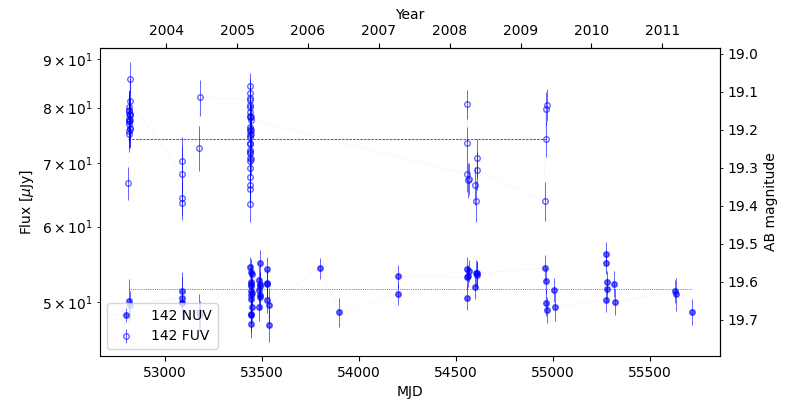

In [11]:
region_name = "WD" #"MDIS_10-800" # "TDS" # _ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
rg_src_id= 142

fig_lc_src = plt.figure("Light curve",figsize=(8, 4), clear=True)
vvis.plot_light_curve(rg, rg_src_ids = rg_src_id,fig=fig_lc_src, flux_var="flux_app") #
plt.show()


#fig = plt.figure(figsize=(8, 6), constrained_layout=True)
plt.errorbar(tt_gap[sel_gap]['t_mean'],tt_gap[sel_gap]['flux'],yerr=tt_gap[sel_gap]['flux_err'],fmt=".")
plt.yscale('log')

#fig2 = plt.figure(figsize=(8, 6), constrained_layout=True)
#ax = plt.gca()
#ax.invert_yaxis()
#plt.errorbar(tt_gap[sel_gap]['t_mean'],tt_gap[sel_gap]['mag_bgsub'],yerr=tt_gap[sel_gap]['mag_bgsub_err_2'],fmt="bo")

In [12]:
# Calculate apperture flux correctin from http://www.galex.caltech.edu/researcher/techdoc-ch5.html
f1 = mag2flux(19)
f2 = mag2flux(19-0.20)
mag = flux2mag(f2)
print(f1,f2,f2/f1, mag)


91.20108393559062 1e-06 Jy 109.64781961431808 1e-06 Jy 1.202264434617413 18.8 mag(AB)
